In [84]:
from typing import Callable, Sequence, Any
from functools import partial
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

from aa_train_utils.model_utils import create_model, save_model_params, load_model_params
from aa_train_utils.dataset_generation import joint, uniform, f6, f5, f2, RegressionDataset , generate_noisy_split_trainingdata
from aa_train_utils.spl_curriculum import SPL_curriculum 

import jax
import jax.numpy as jnp
import jax.tree_util
from jax.scipy.stats.norm import logpdf
from scipy.stats import t
import pickle

import numpy as np
import pickle
import flax
import flax.linen as nn

import optax
import jaxopt
import netket as nk

import tqdm

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  # Import Line2D for custom legend entry
import seaborn as sns

from functions import Fourier, Mixture, Slope, Polynomial, WhiteNoise, Shift
from networks import MixtureNeuralProcess, MLP, MeanAggregator, SequenceAggregator, NonLinearMVN, ResBlock
#from dataloader import MixtureDataset
import pandas as pd
from jax.tree_util import tree_map


[10.0, 28.0, 46.0, 64.0, 82.0, 100.0]
[ 100  380  839 1479 2299 3298]


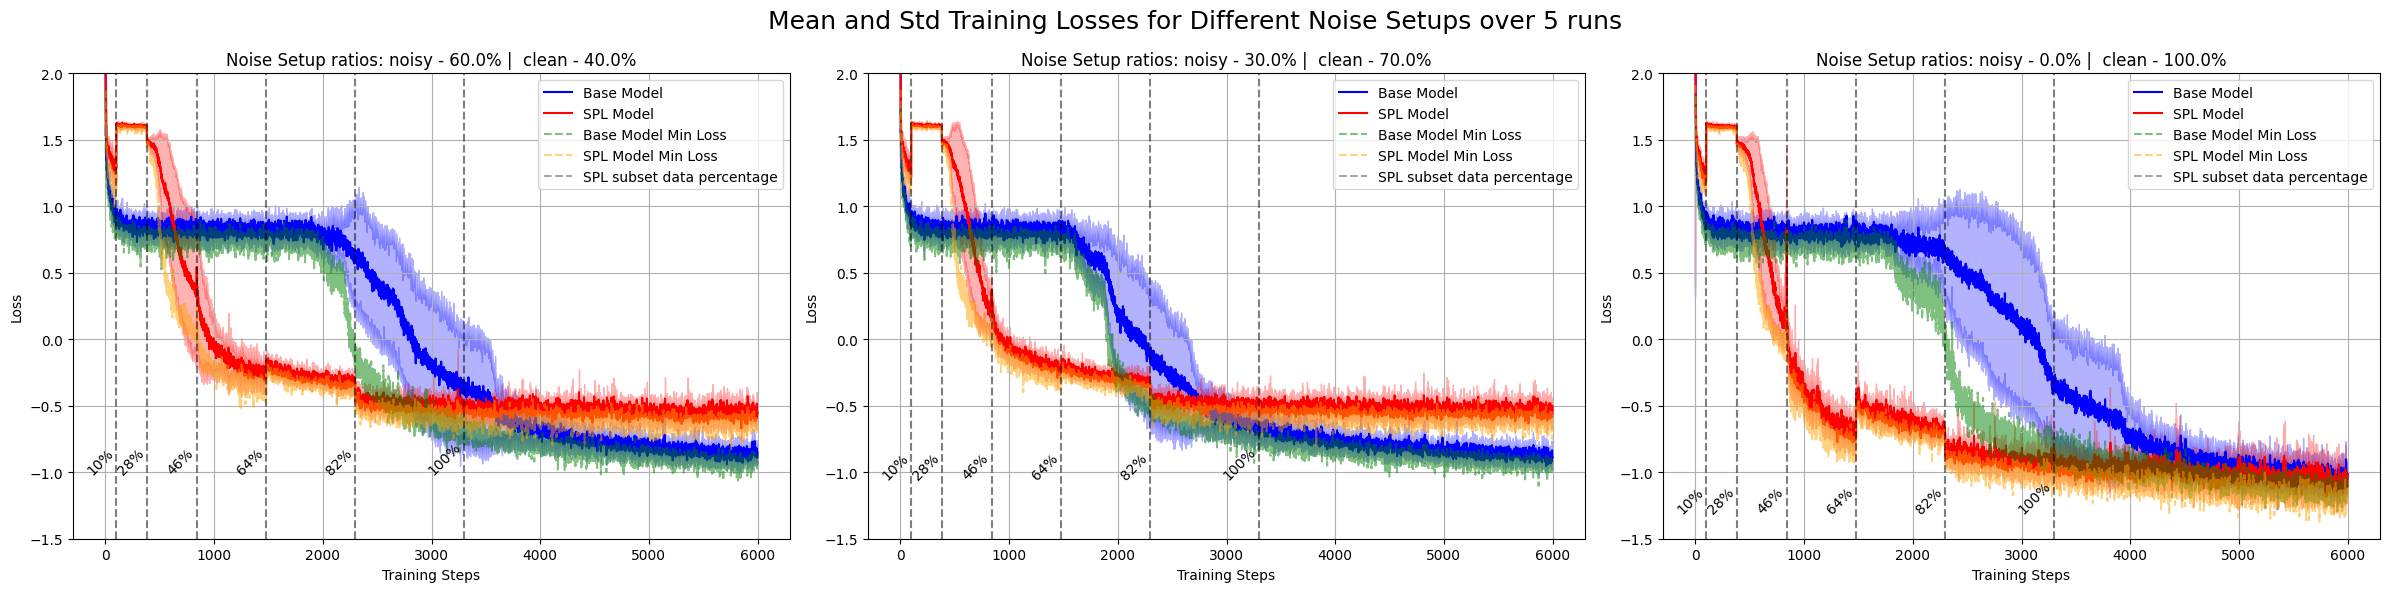

In [31]:
# Firstly we will need to load in the necessary training metrics for a single run. 

# for baseline this takes the form within a given folder (base_0_1)

# Set the experiment directory
experiment_directory = "exp_ds_5runs"

# Lets also load in the curricula weights , its enough to load it in for one , becauase they used the same curricula params. 

spl_logs_path = os.path.join(experiment_directory, "noise_0_1_runs", "spl_0_1_1_curricula_logs.pkl")

batch_size= 128

dataset_size= 128*1000
# Load in 
with open(spl_logs_path, "rb") as f:
    spl_logs_data = pickle.load(f)

spl_subset_percentages = [round(len(w)/dataset_size*100,2) for w in spl_logs_data["curricula_weights"]]
print(spl_subset_percentages)
spl_subset_lengths=np.cumsum([len(w)//128 for w  in spl_logs_data["curricula_weights"]])
print(spl_subset_lengths)

# Get the list of noise setup directories
noise_setup_directories = [d for d in os.listdir(experiment_directory) if os.path.isdir(os.path.join(experiment_directory, d))]

# Define the number of noise setups
num_noise_setups = len(noise_setup_directories)


# Create a figure with subplots for each noise setup
fig, axs = plt.subplots(1, num_noise_setups, figsize=(8 * num_noise_setups, 6))

# Iterate over each noise setup directory
for i, noise_setup_directory in enumerate(noise_setup_directories):
    # Extract noise levels from directory name
    noise_levels = noise_setup_directory.split("_")[1:-1]

    # Initialize lists to store losses for each model
    base_losses = []
    spl_losses = []

    # Get the list of files in the noise setup directory
    saved_files = os.listdir(os.path.join(experiment_directory, noise_setup_directory))

    # Iterate over each file in the noise setup directory
    for file in saved_files:
        if file.endswith("_training_metrics.pkl"):
            model_name, _, _, _, _, _ = file.split("_")
            # Load the training metrics from the file
            with open(os.path.join(experiment_directory, noise_setup_directory, file), "rb") as f:
                training_metrics = pickle.load(f)
            
            # Append losses to the corresponding model's list
            if model_name == "base":
                base_losses.append(training_metrics["training_loss"])
            else:
                spl_losses.append(training_metrics["training_loss"])

    # Convert the lists to numpy arrays
    base_losses = np.array(base_losses)
    spl_losses = np.array(spl_losses)

    # Calculate the mean, minimum, and standard deviation of the losses for each model
    base_mean_loss = np.mean(base_losses, axis=0)
    base_min_loss = np.min(base_losses, axis=0)
    base_std_loss = np.std(base_losses, axis=0)

    spl_mean_loss = np.mean(spl_losses, axis=0)
    spl_min_loss = np.min(spl_losses, axis=0)
    spl_std_loss = np.std(spl_losses, axis=0)

    # Plot the mean losses for each model
    axs[i].plot(base_mean_loss, label="Base Model", color="blue")
    axs[i].fill_between(range(len(base_mean_loss)), base_mean_loss - base_std_loss, base_mean_loss + base_std_loss, color="blue", alpha=0.3)
    axs[i].plot(spl_mean_loss, label="SPL Model", color="red")
    axs[i].fill_between(range(len(spl_mean_loss)), spl_mean_loss - spl_std_loss, spl_mean_loss + spl_std_loss, color="red", alpha=0.3)
   # Plot the minimum losses for each model
    # Plot the minimum losses for each model
    axs[i].plot(base_min_loss, linestyle="--", label="Base Model Min Loss", color="green", alpha=0.5)
    axs[i].plot(spl_min_loss, linestyle="--", label="SPL Model Min Loss", color="orange", alpha=0.5)

    # Plot dashed lines for curriculum stages
    for stage, prcnt in zip(spl_subset_lengths, spl_subset_percentages):
        axs[i].axvline(x=stage, color='black', linestyle='--', alpha=0.5)
    
        y_position = axs[i].get_ylim()[0] + 0.05 * (axs[i].get_ylim()[1] - axs[i].get_ylim()[0])
        axs[i].text(stage, y_position, f'{int(prcnt)}%', rotation=45, verticalalignment='bottom', horizontalalignment='right', color='black')
    # Set title and labels
    axs[i].set_title(f"Noise Setup ratios: noisy - " + str(float(noise_levels[0])*100.0) + "% | " + " clean - " + str(float(noise_levels[1])*100.0) + "%")
    axs[i].set_xlabel("Training Steps")
    axs[i].set_ylabel("Loss")
    axs[i].set_ylim(-1.5, 2)
    axs[i].legend()

    # Show grid
    axs[i].grid(True)

# Add the custom line for the curriculum subset to the legend
custom_line = [Line2D([0], [0], color='gray', linestyle='--', alpha=0.7, label='Curriculum Subset')]
for ax in axs:
    handles, labels = ax.get_legend_handles_labels()
    handles.extend(custom_line)
    labels.append('SPL subset data percentage')


# Set the legend for the last axis
    ax.legend(handles=handles, labels=labels)

# Set the title for the entire figure
fig.suptitle("Mean and Std Training Losses for Different Noise Setups over " + str(len(base_losses)) + " runs", fontsize=18)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

# Save plot
fig.savefig("training_losses.png")

[(12,), (12,), (12,), (12,)]
printing confidence interval return values) [0.70897972 0.7084932  0.70874005 0.70062452 0.77395096 0.84298596
 0.905414   0.94977587 0.95577906 0.96681979 0.95229998 0.96621913] [0.71487832 0.71158457 0.71354754 0.75332067 0.86577338 0.96928535
 0.97195326 0.96243647 0.96591366 0.97919722 0.9724471  0.97692218]
printing confidence interval return values) [0.72534869 0.9407235  0.95092764 0.94808577 0.95115837 0.94819553
 0.97595504 0.95132278 0.95024759 0.95440618 0.94938769 0.95192995] [0.8495452  0.97440641 0.96410739 0.96488135 0.95640311 0.96898368
 0.98332387 0.96793045 0.97590851 0.96555217 0.96419763 0.96132443]
printing confidence interval return values) [1.37134537 1.31366057 1.31018461 1.25958782 1.28763536 1.42476351
 1.45887946 1.4701017  1.51035939 1.48491914 1.51313274 1.53319623] [1.41454465 1.34765733 1.33234595 1.33928911 1.41518273 1.51180392
 1.54169261 1.54168924 1.57836906 1.57387147 1.60742486 1.6175268 ]
printing confidence interval 

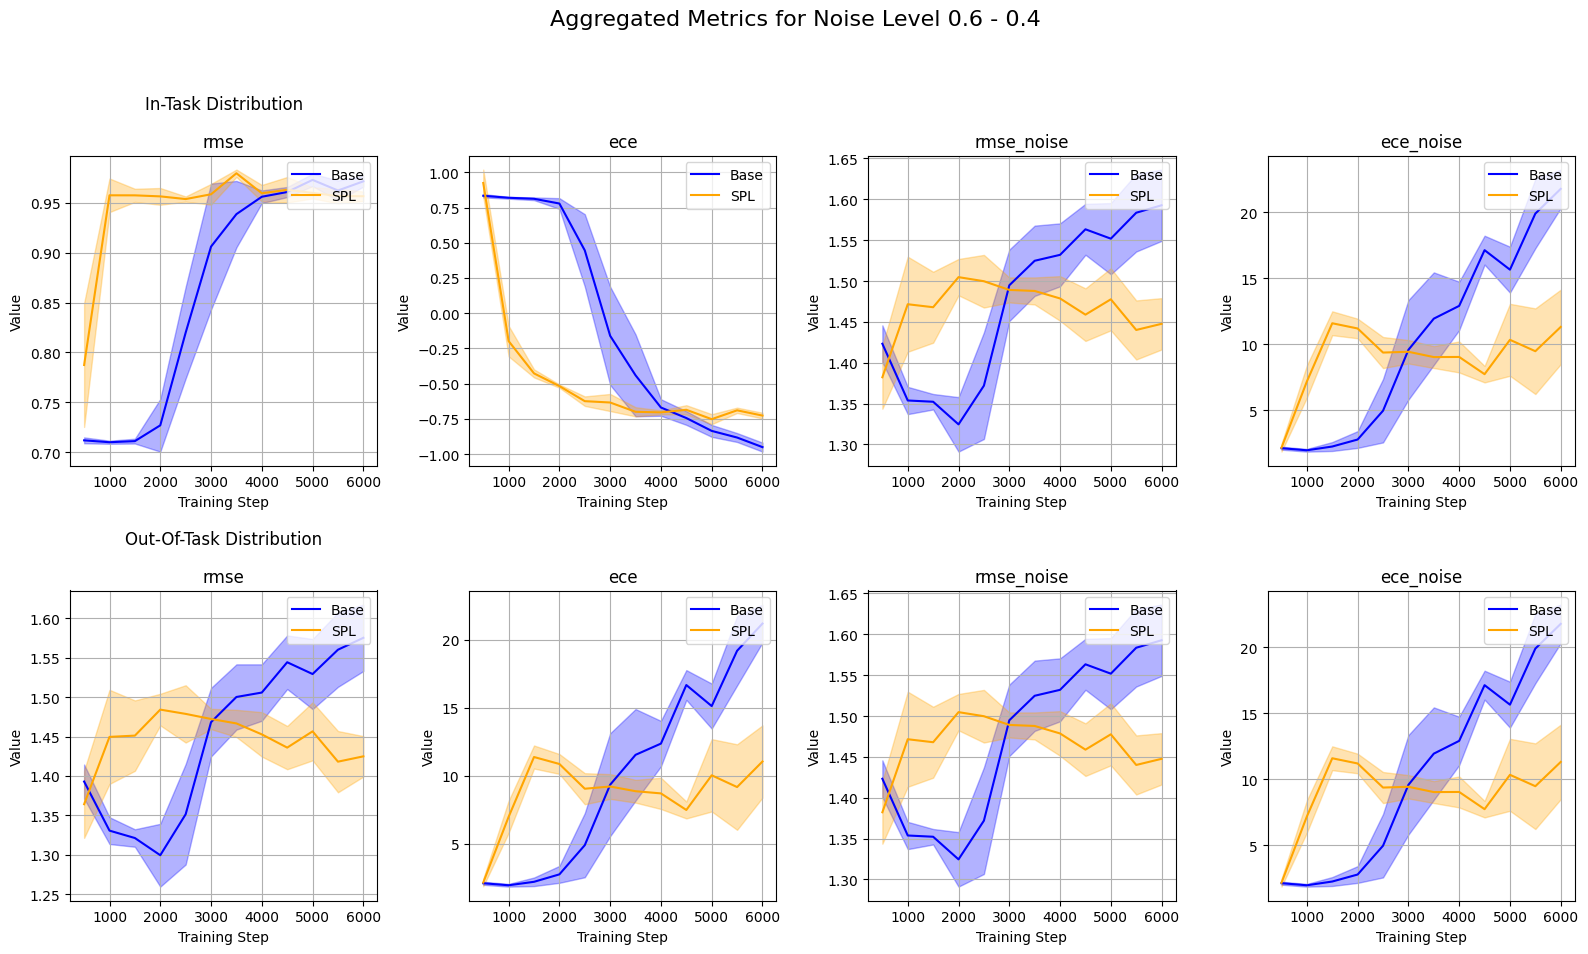

[(12,), (12,), (12,), (12,)]
printing confidence interval return values) [0.70965803 0.70743747 0.70858458 0.79097639 0.888818   0.94651622
 0.95168635 0.95866631 0.96411926 0.95297295 0.96220305 0.96214627] [0.71381779 0.70990654 0.71622303 0.92910867 0.96753943 0.96222295
 0.96584768 0.96687041 0.97772421 0.96710809 0.96991598 0.97057067]
printing confidence interval return values) [0.71628959 0.95168192 0.95253017 0.95329268 0.9399272  0.95627802
 0.94891631 0.94053108 0.96012753 0.95009915 0.94814005 0.94661747] [0.83873301 0.96536857 0.96684483 0.96559199 0.96419989 0.96221425
 0.9697165  0.95968222 0.96884515 0.97298222 0.96555543 0.96182488]
printing confidence interval return values) [1.32337501 1.31254566 1.30079657 1.31865071 1.37157987 1.37709671
 1.43750736 1.46320048 1.46856111 1.46889349 1.48846467 1.49415709] [1.37942695 1.39551396 1.41191251 1.41007145 1.4202227  1.47645145
 1.51209754 1.52428792 1.54642992 1.54567538 1.56564024 1.58544545]
printing confidence interval 

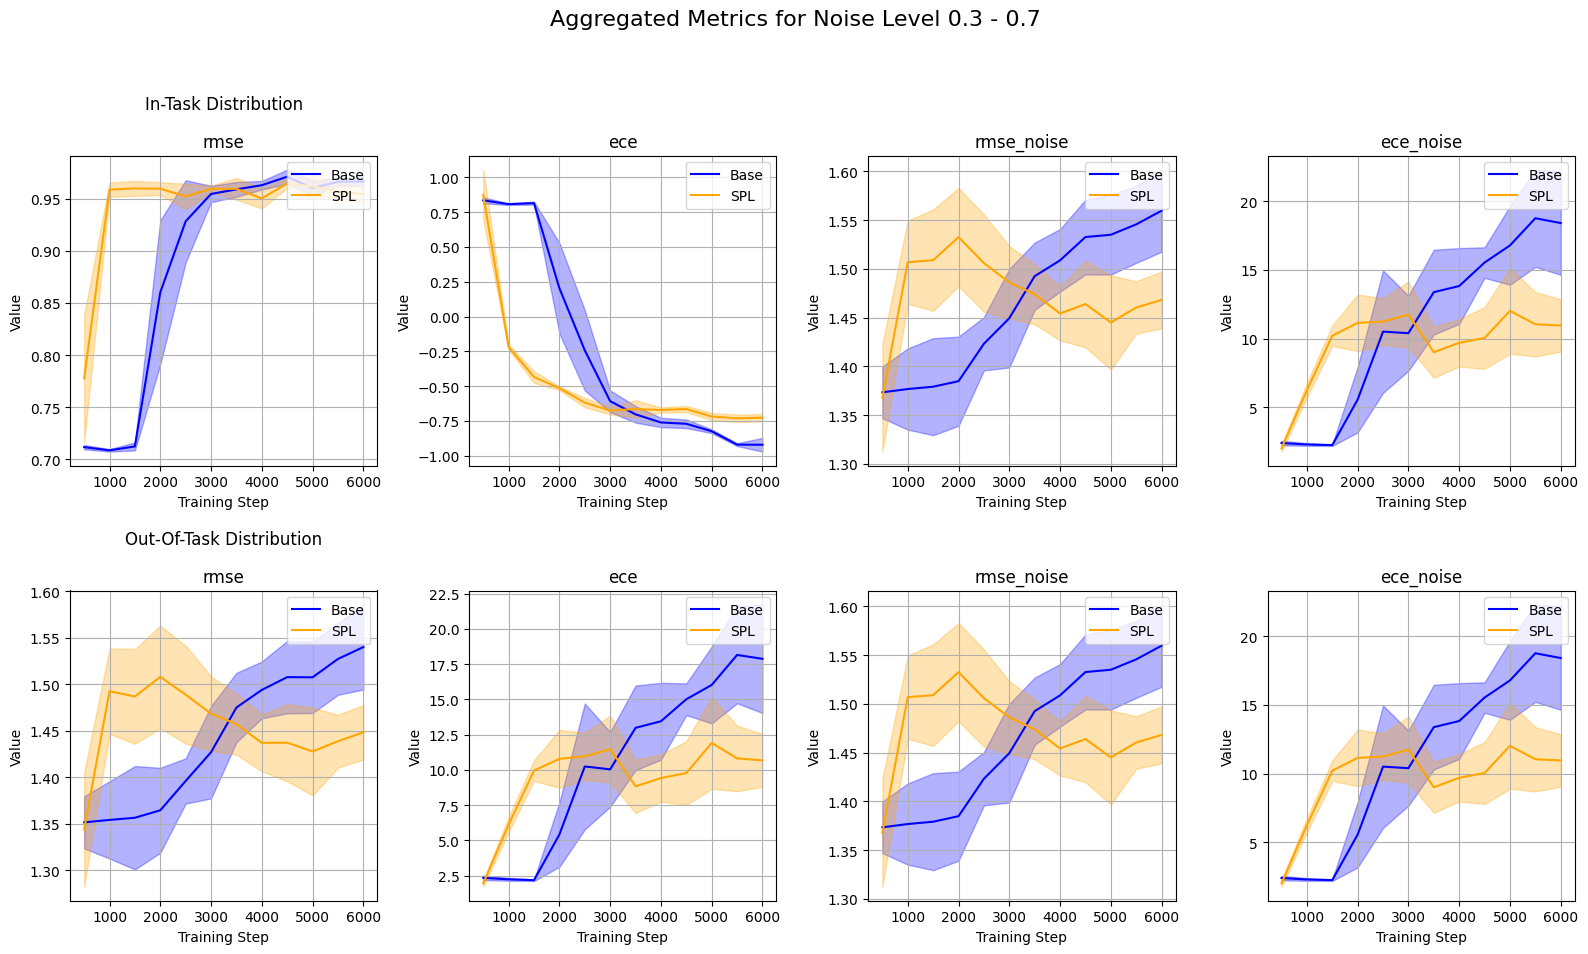

[(12,), (12,), (12,), (12,)]
printing confidence interval return values) [0.70914317 0.70779442 0.70929554 0.70384635 0.70256339 0.78005907
 0.89468456 0.94874035 0.95861664 0.95666546 0.95437093 0.95786244] [0.71289963 0.71221564 0.71363314 0.75798134 0.82707963 0.92551265
 0.9656538  0.96370703 0.96854294 0.96970299 0.96615826 0.96926978]
printing confidence interval return values) [0.71807506 0.94728941 0.95366697 0.9439932  0.9599996  0.96125658
 0.95685365 0.95868143 0.96610038 0.97122034 0.9699165  0.96311941] [0.79569724 0.96457725 0.98438579 0.9627713  0.97054938 0.97191905
 0.96499702 0.97699786 0.98068269 0.98405358 0.97837284 0.97632776]
printing confidence interval return values) [1.3550539  1.3235597  1.31152297 1.24877282 1.21246189 1.22821175
 1.36619886 1.44999091 1.48192614 1.50963077 1.53999013 1.55233674] [1.39401301 1.35236394 1.33477547 1.34357519 1.38292638 1.37522053
 1.46603364 1.52428886 1.56285317 1.57547534 1.60767448 1.60184913]
printing confidence interval 

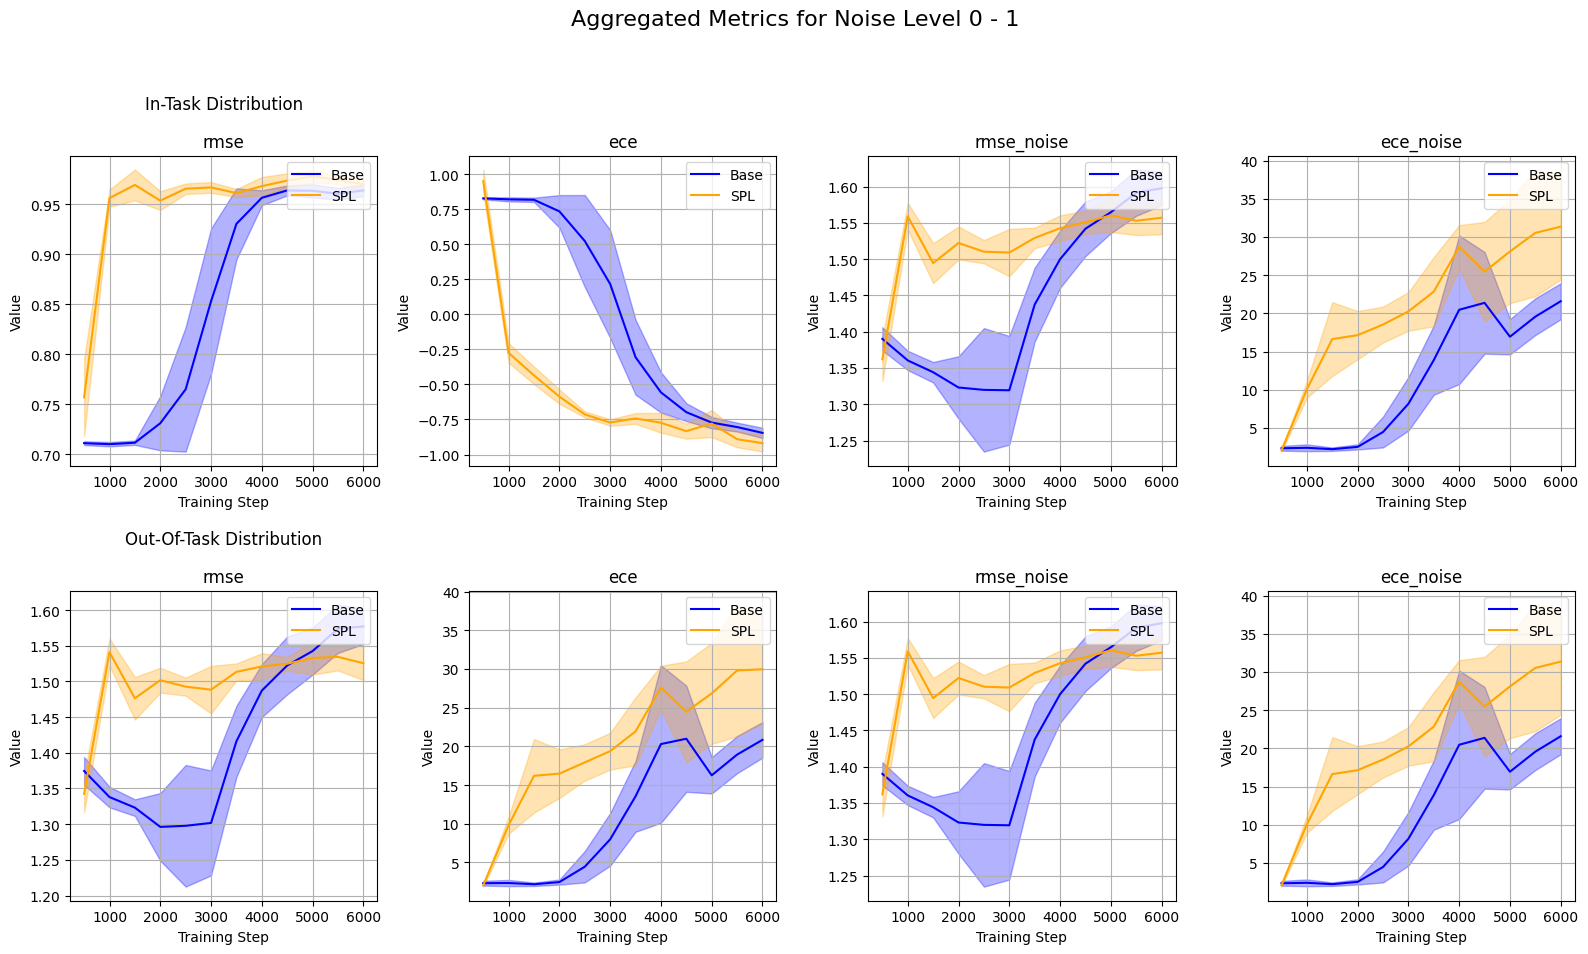

In [90]:
def comb_stds(mean, group_means, group_stds):
    # Calculate the combined standard deviation using the formula

    avg_stdscalc =sum([ (stdi**2 + (mi - mean)**2) for stdi,mi in zip(group_stds, group_means) ] )/len(group_means)

    return np.sqrt(avg_stdscalc)
# Function to separate means and stds
def separate_means_stds(metrics_dict):
    means = {}
    stds = {}
    for k, v in metrics_dict.items():
        mean_values = np.array([x[:, 0] for x in v])
        std_values = np.array([x[:, 1] for x in v])
        means[k] = mean_values
        stds[k] = std_values
    return means, stds

def calculate_confidence_interval(mean, std, n, confidence_level=0.95):
    t_score = t.ppf(1 - (1 - confidence_level) / 2, df=n - 1)
    margin_of_error = t_score * (std / np.sqrt(n))
    lower_bound = mean - margin_of_error
    upper_bound = mean + margin_of_error
    print("printing confidence interval return values)",lower_bound, upper_bound)
    return lower_bound, upper_bound 


def plot_aggregated_metrics(ax, aggregated_base_means, aggregated_base_stds, aggregated_spl_means, aggregated_spl_stds, noise_level, task_type, metrics):
    eval_period_length = 500  # Evaluation period length in training steps

    for i, metric in enumerate(metrics):
        row = i // 2
        col = i % 2

        ax_curr = ax[row, col]

        # Plot base model
        x = [eval_period_length * (j + 1) for j in range(len(aggregated_base_means[metric]))]
        ax_curr.plot(x, aggregated_base_means[metric], label='Base', color='blue')

        # Plot SPL model with slight skew
        ax_curr.plot([xi + 0.1 for xi in x], aggregated_spl_means[metric], label='SPL', color='orange')

        # Plot shaded regions for standard deviations
        ax_curr.fill_between(x, aggregated_base_means[metric] - aggregated_base_stds[metric], aggregated_base_means[metric] + aggregated_base_stds[metric], color='blue', alpha=0.3)
        ax_curr.fill_between([xi + 0.1 for xi in x], aggregated_spl_means[metric] - aggregated_spl_stds[metric], aggregated_spl_means[metric] + aggregated_spl_stds[metric], color='orange', alpha=0.3)

        ax_curr.set_title(f'{metric} - {task_type}')
        ax_curr.set_xlabel('Training Step')
        ax_curr.set_ylabel('Value')
        ax_curr.grid(True)
        ax_curr.legend(loc='upper right')

    fig.suptitle(f'Aggregated Metrics for Noise Level {noise_level}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to accommodate the suptitle


def plot_metrics(ax, metric, base_means, base_stds, spl_means, spl_stds, eval_period_length, n=10, confidence_level=0.95):
    x = [eval_period_length * (j + 1) for j in range(len(base_means))]

    # Calculate confidence intervals for base model
    base_lower, base_upper = calculate_confidence_interval(base_means, base_stds, n, confidence_level)

    # Calculate confidence intervals for SPL model
    spl_lower, spl_upper = calculate_confidence_interval(spl_means, spl_stds, n, confidence_level)

    # Plot base model
    ax.plot(x, base_means, label='Base', color='blue')
    ax.fill_between(x, base_lower, base_upper, color='blue', alpha=0.3)

    # Plot SPL model
    ax.plot([xi + 0.1 for xi in x], spl_means, label='SPL', color='orange')
    ax.fill_between([xi + 0.1 for xi in x], spl_lower, spl_upper, color='orange', alpha=0.3)

    ax.set_title(metric)
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Value')
    ax.grid(True)
    ax.legend(loc='upper right')

def plot_combined_metrics(base_in_means, base_in_stds, spl_in_means, spl_in_stds,
                          base_out_means, base_out_stds, spl_out_means, spl_out_stds,
                          noise_level):
    fig, axs = plt.subplots(2, 4, figsize=(16, 10))  # Increased height to provide more space between rows

    eval_period_length = 500

    metrics = list(base_in_means.keys())

    for i, metric in enumerate(metrics):
        plot_metrics(axs[0, i], metric, base_in_means[metric], base_in_stds[metric], spl_in_means[metric], spl_in_stds[metric], eval_period_length)
        plot_metrics(axs[1, i], metric, base_out_means[metric], base_out_stds[metric], spl_out_means[metric], spl_out_stds[metric], eval_period_length)

    fig.suptitle(f'Aggregated Metrics for Noise Level {noise_level}', fontsize=16)

    # Add subtitles below the main title
    axs[0, 0].annotate('In-Task Distribution', xy=(0.5, 1.15), xycoords='axes fraction', ha='center', fontsize=12)  # Moved annotation higher
    axs[1, 0].annotate('Out-Of-Task Distribution', xy=(0.5, 1.15), xycoords='axes fraction', ha='center', fontsize=12)  # Moved annotation higher

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


experiment_directory = "exp_ds_5runs"

# Get the list of noise setup directories
noise_setup_directories = [d for d in os.listdir(experiment_directory) if os.path.isdir(os.path.join(experiment_directory, d))]

# Define the number of noise setups
num_noise_setups = len(noise_setup_directories)

# Iterate over each noise setup directory
for i, noise_setup_directory in enumerate(noise_setup_directories):
    # Extract noise levels from directory name
    noise_levels = noise_setup_directory.split("_")[1:-1]

    # Initialize lists to store metrics for each model
    base_in_metrics = {"rmse": [], "ece": [], "rmse_noise": [], "ece_noise": []}
    spl_in_metrics = {"rmse": [], "ece": [], "rmse_noise": [], "ece_noise": []}

    base_out_metrics = {"rmse": [], "ece": [], "rmse_noise": [], "ece_noise": []}
    spl_out_metrics = {"rmse": [], "ece": [], "rmse_noise": [], "ece_noise": []}

    # Get the list of files in the noise setup directory
    saved_files = os.listdir(os.path.join(experiment_directory, noise_setup_directory))

    for file in saved_files:
        if file.endswith("_training_metrics.pkl"):
            model_name, _, _, _, _, _ = file.split("_")
            # Load the metrics from the file
            with open(os.path.join(experiment_directory, noise_setup_directory, file), "rb") as f:
                metrics = pickle.load(f)
            
            # Append metrics to the corresponding model's list

            if model_name == "base":
                base_in_metrics["rmse"].append(metrics["training_intask_errors"]["rmse"])
                base_in_metrics["ece"].append(metrics["training_intask_errors"]["ece"])
                base_in_metrics["rmse_noise"].append(metrics["training_outtask_errors"]["rmse_noise"])
                base_in_metrics["ece_noise"].append(metrics["training_outtask_errors"]["ece_noise"])

                base_out_metrics["rmse"].append(metrics["training_outtask_errors"]["rmse"]) 
                base_out_metrics["ece"].append(metrics["training_outtask_errors"]["ece"])
                base_out_metrics["rmse_noise"].append(metrics["training_outtask_errors"]["rmse_noise"])
                base_out_metrics["ece_noise"].append(metrics["training_outtask_errors"]["ece_noise"])
            else:
                spl_in_metrics["rmse"].append(metrics["training_intask_errors"]["rmse"])
                spl_in_metrics["ece"].append(metrics["training_intask_errors"]["ece"])
                spl_in_metrics["rmse_noise"].append(metrics["training_outtask_errors"]["rmse_noise"])
                spl_in_metrics["ece_noise"].append(metrics["training_outtask_errors"]["ece_noise"])

                spl_out_metrics["rmse"].append(metrics["training_outtask_errors"]["rmse"])
                spl_out_metrics["ece"].append(metrics["training_outtask_errors"]["ece"])
                spl_out_metrics["rmse_noise"].append(metrics["training_outtask_errors"]["rmse_noise"])
                spl_out_metrics["ece_noise"].append(metrics["training_outtask_errors"]["ece_noise"])
    

    # Convert the lists to numpy arrays
    
    base_in_metrics = {k: np.array(v) for k, v in base_in_metrics.items()}

    spl_in_metrics = {k: np.array(v) for k, v in spl_in_metrics.items()}

    base_out_metrics = {k: np.array(v) for k, v in base_out_metrics.items()}

    spl_out_metrics = {k: np.array(v) for k, v in spl_out_metrics.items()}

    # Lets aggregate over the runs now lets write it first for base_in_metrics


      # Separate the means and stds for base_in_metrics
    base_in_means, base_in_stds = separate_means_stds(base_in_metrics)
    base_out_means, base_out_stds = separate_means_stds(base_out_metrics)
    spl_in_means, spl_in_stds = separate_means_stds(spl_in_metrics)
    spl_out_means, spl_out_stds = separate_means_stds(spl_out_metrics)

    aggregated_base_in_means = {k: v.mean(axis=0) for k, v in base_in_means.items()} 
    aggregated_base_in_stds = {k: v.std(axis=0) for k, v in base_in_means.items()}
    print([aggregated_base_in_stds[k].shape for k in base_in_means.keys()])

    # Aggregate the means for base_out_metrics
    aggregated_base_out_means = {k: v.mean(axis=0) for k, v in base_out_means.items()}

    # Aggregate the stds for base_out_metrics
    aggregated_base_out_stds = {k: v.std(axis=0) for k, v in base_out_means.items()}


    # Aggregate the means for spl_out_metrics
    aggregated_spl_out_means = {k: v.mean(axis=0) for k, v in spl_out_means.items()}

    # Aggregate the stds for spl_out_metrics
    aggregated_spl_out_stds = {k: v.std(axis=0) for k, v in spl_out_means.items()}


    # Aggregate the means for spl_in_metrics
    aggregated_spl_in_means = {k: v.mean(axis=0) for k, v in spl_in_means.items()}

    aggregated_spl_in_stds = {k: v.std(axis=0) for k, v in spl_in_means.items()}
    
    # Aggregate the means for spl_out_metrics
    aggregated_spl_out_means = {k: v.mean(axis=0) for k, v in spl_out_means.items()}

    # Aggregate the stds for spl_out_metrics
    aggregated_spl_out_stds = {k: v.std(axis=0) for k, v in spl_out_means.items()}


    # Aggregate the means for spl_in_metrics
    aggregated_spl_in_means = {k: v.mean(axis=0) for k, v in spl_in_means.items()}

    # Aggregate the stds for spl_in_metrics
    aggregated_spl_in_stds = {k: v.std(axis=0) for k, v in spl_in_means.items()}
    

    plot_combined_metrics(aggregated_base_in_means, aggregated_base_in_stds, aggregated_spl_in_means, aggregated_spl_in_stds,
                            aggregated_base_out_means, aggregated_base_out_stds, aggregated_spl_out_means, aggregated_spl_out_stds,
                            noise_levels[0] + " - " + noise_levels[1])
    

In [102]:
from spl_training_script import cross_entropy_error, RMSE_means
import re
from aa_train_utils.model_utils import create_model
from aa_train_utils.dataset_generation import generate_dataset, joint, uniform


# Now lets define a function, that will take a model, a sampler, and a test_dataset_size and calculates the performance metrics on them . 
# So we can provide the same key , for the different models, and we can provide different keys over  the models from different runs. 
def calc_metrics_on_sampler(sampler, test_size, model, params, num_posterior_mc, chunk_size, num_context_samples, eval_key):
    # Use chunking
    eval_key_data , eval_model_key = jax.random.split(eval_key)

    x_eval, y_eval = generate_dataset(eval_key_data, test_size, sampler, chunk_size=chunk_size)
    x_eval, y_eval = x_eval[..., None], y_eval[..., None]

    #lets split them into the context and target sets
    x_contexts, x_targets = jnp.split(x_eval, indices_or_sections=(num_context_samples, ), axis=1)
    y_contexts, y_targets = jnp.split(y_eval, indices_or_sections=(num_context_samples, ), axis=1)

    ece_errors = nk.jax.vmap_chunked(partial(cross_entropy_error, model, params, k=num_posterior_mc), in_axes=(0,0,0,0,0), chunk_size=chunk_size)(x_contexts, y_contexts, x_targets, y_targets, jax.random.split(eval_model_key, test_size))
    rmse_errors= nk.jax.vmap_chunked(partial(RMSE_means, model, params, k=num_posterior_mc), in_axes=(0,0,0,0,0), chunk_size=chunk_size)(x_contexts, y_contexts, x_targets, y_targets, jax.random.split(eval_model_key, test_size))

    return ece_errors.mean(), rmse_errors.mean()
def make_sampler(f, points, range):
    return partial(joint, f, partial(uniform, n=points, bounds=(range[0], range[1])))

test_size =128*100 
num_posterior_mc = 1
chunk_size =128 
num_context_samples = 64
num_target_samples = 32

# Lets also setup the distributions for the out of task distribution evaluations. 

# First lets define all the samplers we will be using to create the data. 

# The in task distribution we will be changing the parameters of one by one
f2 = Fourier(n=2, amplitude=.5, period=1.0 , period_range=0.2)
 

#The resulting out of task distributions. 
n_3 = Fourier(n=3, amplitude=0.5, period=1.0, period_range=0.2)
n_4 = Fourier(n=4, amplitude=0.5, period=1.0, period_range=0.2)

amp_1 = Fourier(n=2, amplitude=1.0, period=1.0, period_range=0.2)
amp_2 = Fourier(n=2, amplitude=2.0, period=1.0, period_range=0.2)

per_1_05 = Fourier(n=2, amplitude=0.5, period=1.0, period_range=0.5)
per_15_05 = Fourier(n=2, amplitude=0.5, period=1.5, period_range=0.5)

# Now with the different noise levels we will be using the same functions but with different noise levels.

n_3_noise = WhiteNoise(n_3, 0.2)
n_4_noise = WhiteNoise(n_4, 0.2)

amp_1_noise = WhiteNoise(amp_1, 0.2)
amp_2_noise = WhiteNoise(amp_2, 0.2)

per_1_05_noise = WhiteNoise(per_1_05, 0.2)
per_15_05_noise = WhiteNoise(per_15_05, 0.2)


# Create a dictionary to store the samplers
samplers = {
    'n_3': n_3,
    'n_4': n_4,
    'amp_1.0': amp_1,
    'amp_2.0': amp_2,
    'period_(1.0,0.5)': per_1_05,
    'period_(1.5,0.5)': per_15_05,
    'n_3_noise': n_3_noise,
    'n_4_noise': n_4_noise,
    'amp_1.0_noise': amp_1_noise,
    'amp_2.0_noise': amp_2_noise,
    'period_(1.0,0.5)_noise': per_1_05_noise,
    'period_(1.5,0.5)_noise': per_15_05_noise
}


samplers = {k: make_sampler(v, num_context_samples+num_target_samples, (-1.0, 1.0)) for k, v in samplers.items()}






experiment_directory = "exp_ds_5runs"

# Get the list of noise setup directories

noise_setup_directories = [d for d in os.listdir(experiment_directory) if os.path.isdir(os.path.join(experiment_directory, d))]

# Define the number of noise setups
num_noise_setups = len(noise_setup_directories)

row_index_values = pd.MultiIndex.from_tuples([(k.split("_")[0],k.split("_")[1]) for k in samplers.keys() if "noise" not in k])
# Lets construct the indeces for the columns
noise_setups = ["Noise setup "+"-".join(d.split("_")[1:-1]) for d in noise_setup_directories]


columns = pd.MultiIndex.from_product([noise_setups, ["No Noise", "0.2 Noise"], ["base", "spl"],["rmse", "ece"]])

eval_table_df = pd.DataFrame(index=row_index_values, columns=columns)
# Iterate over each noise setup directory
for i, noise_setup_directory in enumerate(noise_setup_directories):
    # Extract noise levels from directory name
    noise_levels = noise_setup_directory.split("_")[1:-1]
    # Initialize lists to store metrics for each model
    base_in_metrics = {"rmse": [], "ece": [], "rmse_noise": [], "ece_noise": []}
    spl_in_metrics = {"rmse": [], "ece": [], "rmse_noise": [], "ece_noise": []}

    base_out_metrics = {"rmse": [], "ece": [], "rmse_noise": [], "ece_noise": []}
    spl_out_metrics = {"rmse": [], "ece": [], "rmse_noise": [], "ece_noise": []}

    # Get the list of files in the noise setup directory
    saved_files = os.listdir(os.path.join(experiment_directory, noise_setup_directory))

    # Get the list of files in the directory

    # Regular expression to match the files with any word, followed by either integers or floats separated by underscores, and ending with .pkl
    pattern = re.compile(r'\w+_(\d+(\.\d+)?)_(\d+(\.\d+)?)_(\d+(\.\d+)?)\.pkl')

    # Filter the files based on the regular expression
    filtered_files = [f for f in saved_files if pattern.match(f)]

    print(filtered_files)
    

    base_metric_dics= []
    spl_metric_dics=[]
    for file in filtered_files:
        model_name, _, _, run_seed = file.split("_")
        run_seed = int(run_seed.split(".")[0])
        # Load the metrics from the file
        with open(os.path.join(experiment_directory, noise_setup_directory, file), "rb") as f:
            model_params = pickle.load(f)
        
        print(model_name, run_seed)
        # Lets use the run_seed to initialite the model again , but it doesnt mather since the params will be replaced anyway.

        model, junk_params = create_model(jax.random.PRNGKey(int(run_seed)))
        params = model_params

        model_persampler_metrics = {k : {"rmse": [], "ece":[]} for k in samplers.keys()} 

        for sampler_key, sampler in samplers.items():
            ece_error, rmse_error = calc_metrics_on_sampler(sampler, test_size, model, params, num_posterior_mc, chunk_size, num_context_samples, jax.random.PRNGKey(int(run_seed)))
            model_persampler_metrics[sampler_key]["rmse"].append(rmse_error)
            model_persampler_metrics[sampler_key]["ece"].append(ece_error)

        if model_name == "base":
            base_metric_dics.append(model_persampler_metrics)
        else:
            spl_metric_dics.append(model_persampler_metrics) 

    # After we are done calculating the metrics for each model and run. we can get the mean and confidence intervals for each evaluation setup.
    base_means = {k: {m: np.mean([d[k][m] for d in base_metric_dics], axis=0) for m in ["rmse", "ece"]} for k in samplers.keys()} 
    base_std = {k: {m: np.std([d[k][m] for d in base_metric_dics], axis=0) for m in ["rmse", "ece"]} for k in samplers.keys()}
    spl_means = {k: {m: np.mean([d[k][m] for d in spl_metric_dics], axis=0) for m in ["rmse", "ece"]} for k in samplers.keys()}
    spl_std = {k: {m: np.std([d[k][m] for d in spl_metric_dics], axis=0) for m in ["rmse", "ece"]} for k in samplers.keys()}

    base_confidence_intervals = {k: {m: calculate_confidence_interval(base_means[k][m], base_std[k][m], len(base_metric_dics), 0.95) for m in ["rmse", "ece"]} for k in samplers.keys()}

    print(base_confidence_intervals)
    print(base_means)
    spl_confidence_intervals = {k: {m: calculate_confidence_interval(spl_means[k][m], spl_std[k][m], len(spl_metric_dics), 0.95) for m in ["rmse", "ece"]} for k in samplers.keys()}

    base_value_strings = {k: {m: f'{base_means[k][m][0]:.2f} ({base_confidence_intervals[k][m][0][0]:.2f}, {base_confidence_intervals[k][m][1][0]:.2f})' for m in ["rmse", "ece"]} for k in samplers.keys()}
    spl_value_strings = {k: {m: f'{spl_means[k][m][0]:.2f} ({spl_confidence_intervals[k][m][0][0]:.2f}, {spl_confidence_intervals[k][m][1][0]:.2f})' for m in ["rmse", "ece"]} for k in samplers.keys()}

    
    noise_setup = "Noise setup "+"-".join(noise_levels)

    for sampler_key in samplers.keys():
        for metric in ["rmse", "ece"]:

            if("noise" in sampler_key):

                eval_table_df.loc[(sampler_key.split("_")[0], sampler_key.split("_")[1]), (noise_setup, "0.2 Noise", "base", metric)] = base_value_strings[sampler_key][metric]
                eval_table_df.loc[(sampler_key.split("_")[0], sampler_key.split("_")[1]), (noise_setup, "0.2 Noise", "spl", metric)] = spl_value_strings[sampler_key][metric]
            else:
                eval_table_df.loc[(sampler_key.split("_")[0], sampler_key.split("_")[1]), (noise_setup, "No Noise", "base", metric)] = base_value_strings[sampler_key][metric]
                eval_table_df.loc[(sampler_key.split("_")[0], sampler_key.split("_")[1]), (noise_setup, "No Noise", "spl", metric)] = spl_value_strings[sampler_key][metric]

print(eval_table_df)

['base_0.6_0.4_13.pkl', 'base_0.6_0.4_11.pkl', 'base_0.6_0.4_12.pkl', 'base_0.6_0.4_10.pkl', 'spl_0.6_0.4_12.pkl', 'spl_0.6_0.4_13.pkl', 'base_0.6_0.4_14.pkl', 'spl_0.6_0.4_11.pkl', 'spl_0.6_0.4_10.pkl', 'spl_0.6_0.4_14.pkl']
base 13
base 11
base 12
base 10
spl 12
spl 13
base 14
spl 11
spl 10
spl 14
printing confidence interval return values) [0.62063636] [0.65246323]
printing confidence interval return values) [10.00400548] [15.18051779]
printing confidence interval return values) [0.75031204] [0.78875997]
printing confidence interval return values) [12.23318427] [18.74303468]
printing confidence interval return values) [0.15469143] [0.18364441]
printing confidence interval return values) [-0.27071567] [0.23275221]
printing confidence interval return values) [1.05684734] [1.13447185]
printing confidence interval return values) [12.34174149] [36.77221979]
printing confidence interval return values) [0.27375719] [0.29670744]
printing confidence interval return values) [1.33144752] [2.53

In [131]:
print(eval_table_df.columns)
print(eval_table_df.index)
print(eval_table_df.to_latex())

print(eval_table_df.T.to_latex())

print(eval_table_df.T.index)

eval_table_df.T.index.rename(["Noise setup", "Noise level", "Model", "Metric"], inplace=True)
print(eval_table_df.T.index.names)
eval_table_df.T.columns.rename(["Param Type", "Param Value"], inplace=True)
print(eval_table_df.T.columns)

MultiIndex([('Noise setup 0.6-0.4',  'No Noise', 'base', 'rmse'),
            ('Noise setup 0.6-0.4',  'No Noise', 'base',  'ece'),
            ('Noise setup 0.6-0.4',  'No Noise',  'spl', 'rmse'),
            ('Noise setup 0.6-0.4',  'No Noise',  'spl',  'ece'),
            ('Noise setup 0.6-0.4', '0.2 Noise', 'base', 'rmse'),
            ('Noise setup 0.6-0.4', '0.2 Noise', 'base',  'ece'),
            ('Noise setup 0.6-0.4', '0.2 Noise',  'spl', 'rmse'),
            ('Noise setup 0.6-0.4', '0.2 Noise',  'spl',  'ece'),
            ('Noise setup 0.3-0.7',  'No Noise', 'base', 'rmse'),
            ('Noise setup 0.3-0.7',  'No Noise', 'base',  'ece'),
            ('Noise setup 0.3-0.7',  'No Noise',  'spl', 'rmse'),
            ('Noise setup 0.3-0.7',  'No Noise',  'spl',  'ece'),
            ('Noise setup 0.3-0.7', '0.2 Noise', 'base', 'rmse'),
            ('Noise setup 0.3-0.7', '0.2 Noise', 'base',  'ece'),
            ('Noise setup 0.3-0.7', '0.2 Noise',  'spl', 'rmse'),
          

/tmp/ipykernel_23616/2733647562.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  subset_df_numeric = subset_df.applymap(lambda x: float(x.split()[0]))  # Convert values to numeric


KeyError: '(1.0,0.5)'

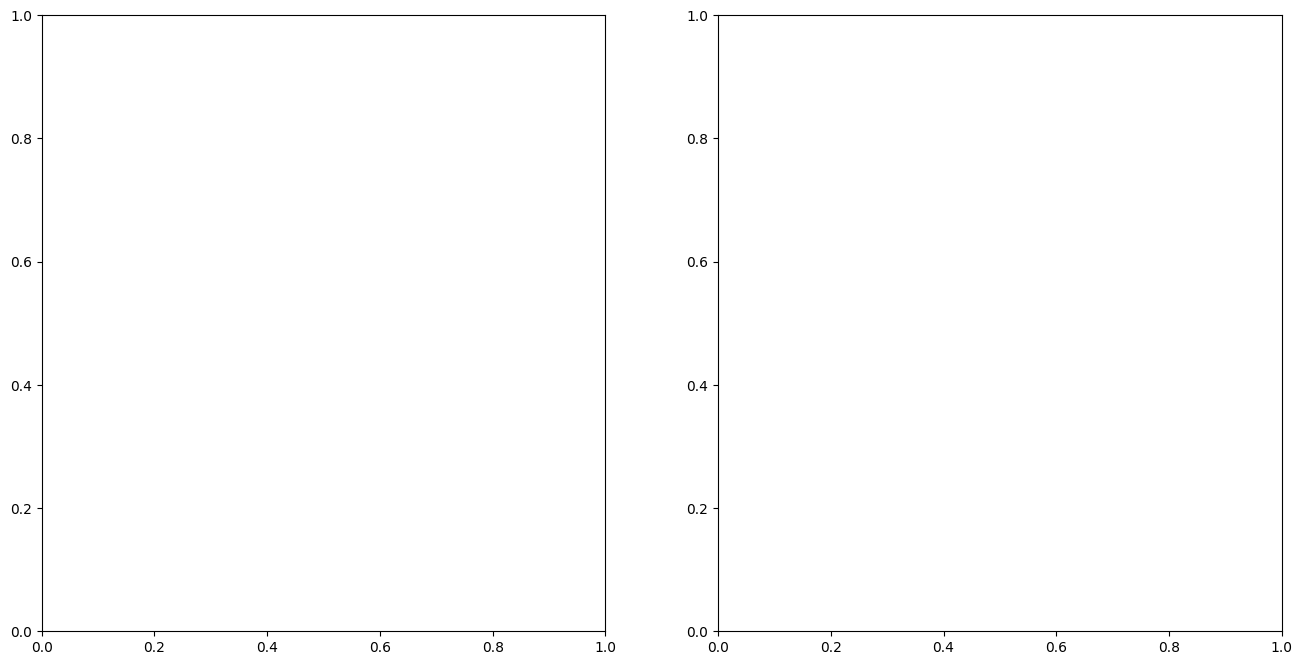

In [142]:

noise_setups = eval_table_df.T.index.get_level_values(0).unique()

# Iterate over noise setups
for setup in noise_setups:
    subset_df = eval_table_df.T.loc[setup]
    subset_df_numeric = subset_df.applymap(lambda x: float(x.split()[0]))  # Convert values to numeric
    subset_df_unstacked = subset_df_numeric.unstack(level="Model")

    # Create a new figure for each noise setup
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

    # Iterate over metrics
    for i, metric in enumerate(['rmse', 'ece']):
        # Plot the data
        ax = subset_df_unstacked[metric].plot(kind='bar', ax=axes[i], title=f'{metric.upper()} for {setup} Noise Setup')
        
        # Add gridlines
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        
        # Rotate x-axis labels for better readability
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        
        # Add labels and legend
        ax.set_xlabel('(Param type, Value, Model)')
        ax.set_ylabel(f'{metric.upper()} Value')
        ax.legend(title='Model')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    # Show plot
    plt.show()

In [97]:
import pandas as pd
import numpy as np

# Define different index values for each row


row_index_values = pd.MultiIndex.from_tuples([(k.split("_")[0],k.split("_")[1]) for k in samplers.keys() if "noise" not in k])

# Lets construct the indeces for the columns
noise_setup_directories = [d for d in os.listdir(experiment_directory) if os.path.isdir(os.path.join(experiment_directory, d))]
noise_setups = ["Noise setup "+"-".join(d.split("_")[1:-1]) for d in noise_setup_directories]


columns = pd.MultiIndex.from_product([noise_setups, ["No Noise", "0.2 Noise"], ["base", "spl"] , ["rmse", "ece"]])
print(columns)

print(row_index_values)
# Define column names and levels
# Create a list of lists containing string values for each row
data = [["string_value" for _ in range(len(columns))] for _ in range(len(row_index_values))]

print(pd.DataFrame(index=row_index_values, columns=columns).to_latex())





MultiIndex([('Noise setup 0.6-0.4',  'No Noise', 'base', 'rmse'),
            ('Noise setup 0.6-0.4',  'No Noise', 'base',  'ece'),
            ('Noise setup 0.6-0.4',  'No Noise',  'spl', 'rmse'),
            ('Noise setup 0.6-0.4',  'No Noise',  'spl',  'ece'),
            ('Noise setup 0.6-0.4', '0.2 Noise', 'base', 'rmse'),
            ('Noise setup 0.6-0.4', '0.2 Noise', 'base',  'ece'),
            ('Noise setup 0.6-0.4', '0.2 Noise',  'spl', 'rmse'),
            ('Noise setup 0.6-0.4', '0.2 Noise',  'spl',  'ece'),
            ('Noise setup 0.3-0.7',  'No Noise', 'base', 'rmse'),
            ('Noise setup 0.3-0.7',  'No Noise', 'base',  'ece'),
            ('Noise setup 0.3-0.7',  'No Noise',  'spl', 'rmse'),
            ('Noise setup 0.3-0.7',  'No Noise',  'spl',  'ece'),
            ('Noise setup 0.3-0.7', '0.2 Noise', 'base', 'rmse'),
            ('Noise setup 0.3-0.7', '0.2 Noise', 'base',  'ece'),
            ('Noise setup 0.3-0.7', '0.2 Noise',  'spl', 'rmse'),
          